# Описание проекта
Требуется напиcать несколько SQL-запросов в базу данных StackOverflow — сервиса вопросов и ответов о программировании.

ER-диаграмма
![](https://pictures.s3.yandex.net/resources/Frame_353_1_1664969443.png)

## Первая часть

### Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

SELECT COUNT(*)  
FROM stackoverflow.posts  
WHERE post_type_id = 1 AND (score > 300 OR favorites_count >= 100)

### Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно?
Результат округлите до целого числа.

WITH tab AS  
    (SELECT  
        CAST(DATE_TRUNC('day', creation_date) AS date),  
        SUM(post_type_id) AS count_day  
    FROM StackOverflow.posts  
    WHERE creation_date::date BETWEEN '2008-11-01' AND '2008-11-18' AND post_type_id = 1  
    GROUP BY CAST(DATE_TRUNC('day', creation_date) AS date)  
    ORDER BY 1)  
SELECT ROUND(SUM(count_day) / COUNT(*), 0)  
FROM tab

### Сколько пользователей получили значки сразу в день регистрации? 
Выведите количество уникальных пользователей.

SELECT COUNT(DISTINCT u.id)  
FROM StackOverflow.users u  
JOIN StackOverflow.badges b ON u.id=b.user_id  
WHERE u.creation_date::date=b.creation_date::date  

### Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

SELECT COUNT(DISTINCT v.post_id)  
FROM stackoverflow.users u  
JOIN stackoverflow.posts p ON u.id=p.user_id  
JOIN stackoverflow.votes v ON p.id=v.post_id  
WHERE display_name = 'Joel Coehoorn' 

### Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. 
Таблица должна быть отсортирована по полю id.

SELECT *,  
    ROW_NUMBER() OVER(ORDER BY id DESC) AS rank  
FROM stackoverflow.vote_types  
ORDER BY 1

### Отберите 10 пользователей, которые поставили больше всего голосов типа Close. 
Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

SELECT v.user_id,  
    count(*)  
FROM stackoverflow.posts p  
JOIN stackoverflow.votes v ON p.id=v.post_id  
JOIN stackoverflow.vote_types v_t ON v.vote_type_id=v_t.id  
WHERE v_t.name = 'Close'  
GROUP BY v.user_id  
ORDER BY 2 DESC, 1 DESC  
LIMIT 10  

### Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно. 
Отобразите несколько полей:  
- идентификатор пользователя;  
- число значков;  
- место в рейтинге — чем больше значков, тем выше рейтинг.  

Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

SELECT u.id,  
       COUNT(b.id),  
       DENSE_RANK() OVER (ORDER BY COUNT(b.id) DESC)  
FROM stackoverflow.users AS u  
LEFT JOIN stackoverflow.badges AS b ON u.id = b.user_id  
WHERE b.creation_date::date BETWEEN '2008-11-15' AND '2008-12-15'  
GROUP BY u.id   
ORDER BY 2 DESC, 1 ASC  
LIMIT 10

### Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:  
- заголовок поста;  
- идентификатор пользователя;  
- число очков поста;  
- среднее число очков пользователя за пост, округлённое до целого числа.  

Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

SELECT title,  
    user_id,  
    score,  
    ROUND(AVG(score) OVER(PARTITION BY user_id)) -- ORDER BY user_id )  
FROM stackoverflow.posts  
WHERE title <> '' AND score <> 0

### Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков.
Посты без заголовков не должны попасть в список.

WITH tab AS  
    (SELECT  
        user_id,  
        COUNT(name) AS cnt  
    FROM stackoverflow.badges  
    GROUP BY user_id  
    HAVING COUNT(name) > 1000)  
  
SELECT p.title  
FROM tab  
LEFT JOIN stackoverflow.posts p ON tab.user_id=p.user_id  
WHERE p.title IS NOT NULL

### Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). 
Разделите пользователей на три группы в зависимости от количества просмотров их профилей:  
- пользователям с числом просмотров больше либо равным 350 присвойте группу 1;  
- пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;  
- пользователям с числом просмотров меньше 100 — группу 3.  

Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу.

SELECT  
    id,  
    views,  
    CASE  
        WHEN views >= 350 THEN 1  
        WHEN views >= 100 AND views < 350 THEN 2  
        WHEN views < 100 THEN 3  
    END AS groop  
FROM stackoverflow.users  
WHERE (location LIKE '%United States%') AND views <> 0

### Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. 
Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

WITH tab AS  
    (SELECT  
        id,  
        views,  
        CASE  
            WHEN views >= 350 THEN 1  
            WHEN views >= 100 AND views < 350 THEN 2  
            WHEN views < 100 THEN 3  
        END AS groop  
    FROM stackoverflow.users  
    WHERE (location LIKE '%United States%') AND views <> 0),  
tab1 AS  
    (SELECT  
        groop,  
        MAX(views) as v  
    FROM tab  
    GROUP BY groop)  
SELECT   
    id,  
    tab.groop,  
    views  
FROM tab  
JOIN tab1 ON tab.views=tab1.v  
ORDER BY 2, 1

### Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года.
Сформируйте таблицу с полями:  
- номер дня;  
- число пользователей, зарегистрированных в этот день;  
- сумму пользователей с накоплением.

SELECT  
    EXTRACT(DAY FROM creation_date::date),  
    COUNT(*),  
    SUM(COUNT(*)) OVER(ORDER BY EXTRACT(DAY FROM creation_date::date))  
FROM stackoverflow.users  
WHERE creation_date::date BETWEEN '2008-11-01' AND '2008-11-30'  
GROUP BY 1

### Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. 
Отобразите:  
- идентификатор пользователя;  
- разницу во времени между регистрацией и первым постом.

WITH tab AS  
    (SELECT  
        DISTINCT  
        p.user_id,  
        FIRST_VALUE(p.creation_date) OVER(PARTITION BY p.user_id ORDER BY p.creation_date) AS first_post,  
        u.creation_date  
    FROM stackoverflow.posts p  
    JOIN stackoverflow.users u ON p.user_id=u.id)  
SELECT  
    user_id,  
    first_post - creation_date  
FROM tab

## Вторая часть

### Выведите общую сумму просмотров постов за каждый месяц 2008 года. 
Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

SELECT  
    CAST(DATE_TRUNC('month', creation_date) AS date),  
    SUM(views_count)  
FROM stackoverflow.posts  
GROUP BY CAST(DATE_TRUNC('month', creation_date) AS date)  
ORDER BY 2 DESC

### Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. 
Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. Отсортируйте результат по полю с именами в лексикографическом порядке.

SELECT  
    u.display_name AS name,  
    COUNT(DISTINCT user_id) AS cnt  
FROM stackoverflow.users u  
JOIN stackoverflow.posts p ON u.id=p.user_id  
JOIN stackoverflow.post_types p_t ON p.post_type_id=p_t.id  
WHERE p_t.type = 'Answer' AND p.creation_date::date <= (u.creation_date::date + INTERVAL '1 month')  
GROUP BY u.display_name  
HAVING COUNT(*) > 100  
ORDER BY 1

### Выведите количество постов за 2008 год по месяцам. 
Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

SELECT  
    DISTINCT DATE_TRUNC('MONTH', creation_date)::date,  
    COUNT(id) AS cnt  
FROM stackoverflow.posts  
WHERE user_id IN (  
        SELECT DISTINCT u.id  
        FROM stackoverflow.posts AS p  
        JOIN stackoverflow.users AS u ON p.user_id = u.id  
        WHERE DATE_TRUNC('MONTH', u.creation_date) = '2008-09-01'  
              AND DATE_TRUNC('MONTH', p.creation_date) = '2008-12-01'  
                 )  
GROUP BY 1  
ORDER BY 1 DESC

### Используя данные о постах, выведите несколько полей:  
- идентификатор пользователя, который написал пост;  
- дата создания поста;  
- количество просмотров у текущего поста;  
- сумму просмотров постов автора с накоплением. 

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

SELECT  
    user_id,  
    creation_date,  
    views_count,  
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date)  
FROM stackoverflow.posts  
ORDER BY 1, 2

### Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой?
Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.

WITH  
tab AS  
    (SELECT creation_date::date,  
           user_id  
    FROM stackoverflow.posts  
    WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'),  
tab1 AS  
    (SELECT   
        COUNT(DISTINCT creation_date) as cnt,  
        user_id  
    FROM tab  
    GROUP BY user_id)  
SELECT ROUND(AVG(cnt))  
FROM tab1

### На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? 
Отобразите таблицу со следующими полями:  
- номер месяца;  
- количество постов за месяц;  
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.  

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.  
Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип numeric.

SELECT  
    EXTRACT(MONTH FROM creation_date::date),  
    COUNT(*) AS cnt,  
    ROUND((100 * CAST(COUNT(*) AS numeric) / LAG(COUNT(*), 1) OVER (ORDER BY COUNT(*) DESC) - 100),2)  
FROM stackoverflow.posts  
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'  
GROUP BY EXTRACT(MONTH FROM creation_date::date)

### Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. 
Выведите данные за октябрь 2008 года в таком виде:  
- номер недели;  
- дата и время последнего поста, опубликованного на этой неделе.

WITH  
tab1 AS  
    (SELECT  
        user_id,  
        COUNT(*)  
    FROM stackoverflow.posts  
    GROUP BY user_id  
    ORDER BY 2 DESC  
    LIMIT 1),  
tab2 AS  
    (SELECT  
        EXTRACT(WEEK FROM creation_date::date),  
        creation_date  
    FROM stackoverflow.posts p  
    JOIN tab1 ON p.user_id = tab1.user_id  
    WHERE creation_date::date BETWEEN '2008-10-01' AND '2008-10-31'  
    ORDER BY 2),  
tab3 AS  
    (SELECT  
        LAST_VALUE(creation_date) OVER(PARTITION BY date_part)  
    FROM tab2)  
SELECT  
    date_part,  
    creation_date  
FROM tab3  
WHERE creation_date = last_value

## Третья часть

In [2]:
!pip install sqlalchemy

In [3]:
!pip install psycopg2-binary

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [5]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
} 

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
engine = create_engine(connection_string)

In [8]:
query = '''
WITH profile AS
  (SELECT user_id,
          dt,
          COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
   FROM online_store.profiles
   WHERE channel = 'Organic'),
sessions AS 
(SELECT user_id,
        session_start::date AS session_date
FROM online_store.sessions
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''

In [9]:
retention_rate_df = pd.read_sql_query(query, con = engine)

In [10]:
retention_rate_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2020-06-14,2020-06-14,5098,5098,100.00
1,2020-06-14,2020-06-15,2647,5098,51.92
2,2020-06-14,2020-06-16,1836,5098,36.01
3,2020-06-14,2020-06-17,1403,5098,27.52
4,2020-06-14,2020-06-18,1085,5098,21.28
...,...,...,...,...,...
100,2020-06-25,2020-06-26,2460,4777,51.50
101,2020-06-25,2020-06-27,1683,4777,35.23
102,2020-06-26,2020-06-26,5366,5366,100.00
103,2020-06-26,2020-06-27,2802,5366,52.22


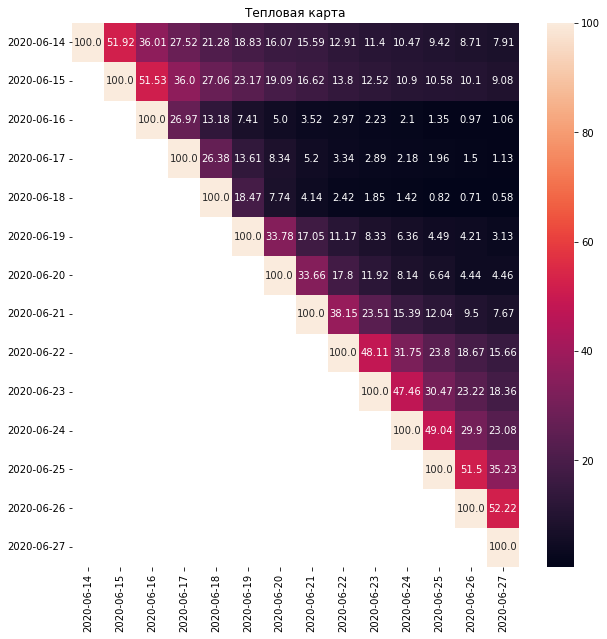

In [11]:
# создаём сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

In [12]:
query = '''WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_day_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01';'''

In [13]:
churn_rate_df = pd.read_sql_query(query, con = engine)

In [14]:
churn_rate_df

,start_mn,event_mn,users_cnt,previous_day_users_cnt,churn_rate
0,2018-01-01,2018-01-01,257,NaN,NaN
1,2018-01-01,2018-02-01,67,257.0,73.93
2,2018-01-01,2018-03-01,41,67.0,38.81
3,2018-01-01,2018-04-01,44,41.0,-7.32
4,2018-01-01,2018-05-01,42,44.0,4.55
5,2018-01-01,2018-06-01,21,42.0,50.00
6,2018-01-01,2018-07-01,11,21.0,47.62
7,2018-01-01,2018-08-01,3,11.0,72.73
8,2018-02-01,2018-02-01,226,NaN,NaN
9,2018-02-01,2018-03-01,59,226.0,73.89


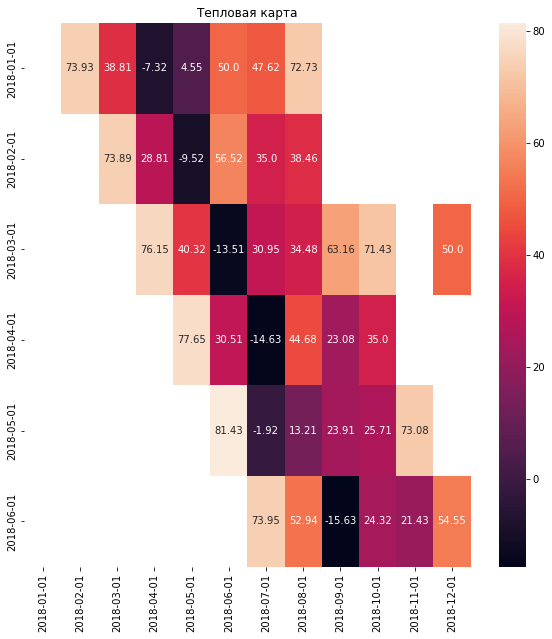

In [21]:
# создаём сводную таблицу с результатами
churn = churn_rate_df.pivot('start_mn', 'event_mn', 'churn_rate')
churn.index = [str(x)[0:10] for x in churn.index]
churn.columns = [str(x)[0:10] for x in churn.columns]

# строим хитмэп
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(churn, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

In [16]:
query = '''
EXPLAIN ANALYZE
SELECT order_id,
       o.user_id,
       user_orders_cnt
FROM tools_shop.orders o JOIN
  (SELECT user_id, 
          COUNT(*) AS user_orders_cnt
   FROM tools_shop.orders
   GROUP BY 1) uo ON uo.user_id = o.user_id;
'''

In [17]:
df = pd.read_sql_query(query, con = engine)

In [18]:
df

,QUERY PLAN
0,Hash Join (cost=1011.11..1409.63 rows=18971 w...
1,Hash Cond: (o.user_id = uo.user_id)
2,-> Seq Scan on orders o (cost=0.00..348.71...
3,-> Hash (cost=792.83..792.83 rows=17463 wi...
4,Buckets: 32768 Batches: 1 Memory Usa...
5,-> Subquery Scan on uo (cost=443.57....
6,-> HashAggregate (cost=443.57....
7,Group Key: orders.user_id
8,-> Seq Scan on orders (c...
9,Planning Time: 0.212 ms


In [19]:
query = '''
EXPLAIN ANALYZE
SELECT order_id,
       user_id,
       COUNT(*) OVER (PARTITION BY user_id) AS user_orders_cnt
FROM tools_shop.orders;
'''

In [20]:
pd.read_sql_query(query, con = engine)

,QUERY PLAN
0,WindowAgg (cost=1696.74..2028.74 rows=18971 w...
1,-> Sort (cost=1696.74..1744.17 rows=18971 ...
2,Sort Key: user_id
3,Sort Method: quicksort Memory: 1658kB
4,-> Seq Scan on orders (cost=0.00..34...
5,Planning Time: 0.043 ms
6,Execution Time: 16.467 ms
